In [6]:
from lib.utils import *
from lib.models import *
from lib.ekyn import *
from lib.env import *
from lib.datasets import *

In [7]:
class Gandalf(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.encoder = Frodo(n_features=5000,device=DEVICE).to(DEVICE)
        self.lstm = nn.LSTM(16,32,bidirectional=True)
        self.fc1 = nn.Linear(64,3)
    def forward(self,x_2d,classification=True):
        x_2d = x_2d.view(-1,9,1,5000)
        x = torch.Tensor().to(DEVICE)
        for t in range(x_2d.size(1)):
            xi = self.encoder(x_2d[:,t,:,:],classification=False)
            x = torch.cat([x,xi.unsqueeze(0)],dim=0)
        out,_ = self.lstm(x)
        if(classification):
            x = self.fc1(out[-1])
        else:
            x = out[-1]
        return x
model = Gandalf()
model.load_state_dict(torch.load(f'gandalf_spindle_fold_14/best_model.pt'))
model.to(DEVICE)
criterion = torch.nn.CrossEntropyLoss()

In [8]:
FOLD = 14
ids = ['A1','A2','A3','A4','B1','B2','B3','B4','C1','C2','C3','C4','C5','C6','C7','C8','D1','D2','D3','D4','D5','D6']
test_id = ids[FOLD]
print(test_id)
ids.remove(test_id)
subjects = [load_spindle_eeg_label_pair(cohort=id[0],subject=id[1]) for id in [test_id]]
Xs = [subject[0] for subject in subjects]
ys = [subject[1] for subject in subjects]
devloader = DataLoader(dataset=SSDataset(Xs,ys,range(8640)),batch_size=32,shuffle=False)

C7
Extracting EDF parameters from /home/andrew/sleep/data/spindle/CohortC/recordings/C7.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [80]:
loss,report,y_true,y_pred,y_logits = evaluate(devloader,model,criterion,DEVICE)

100%|██████████| 270/270 [00:22<00:00, 12.16it/s]


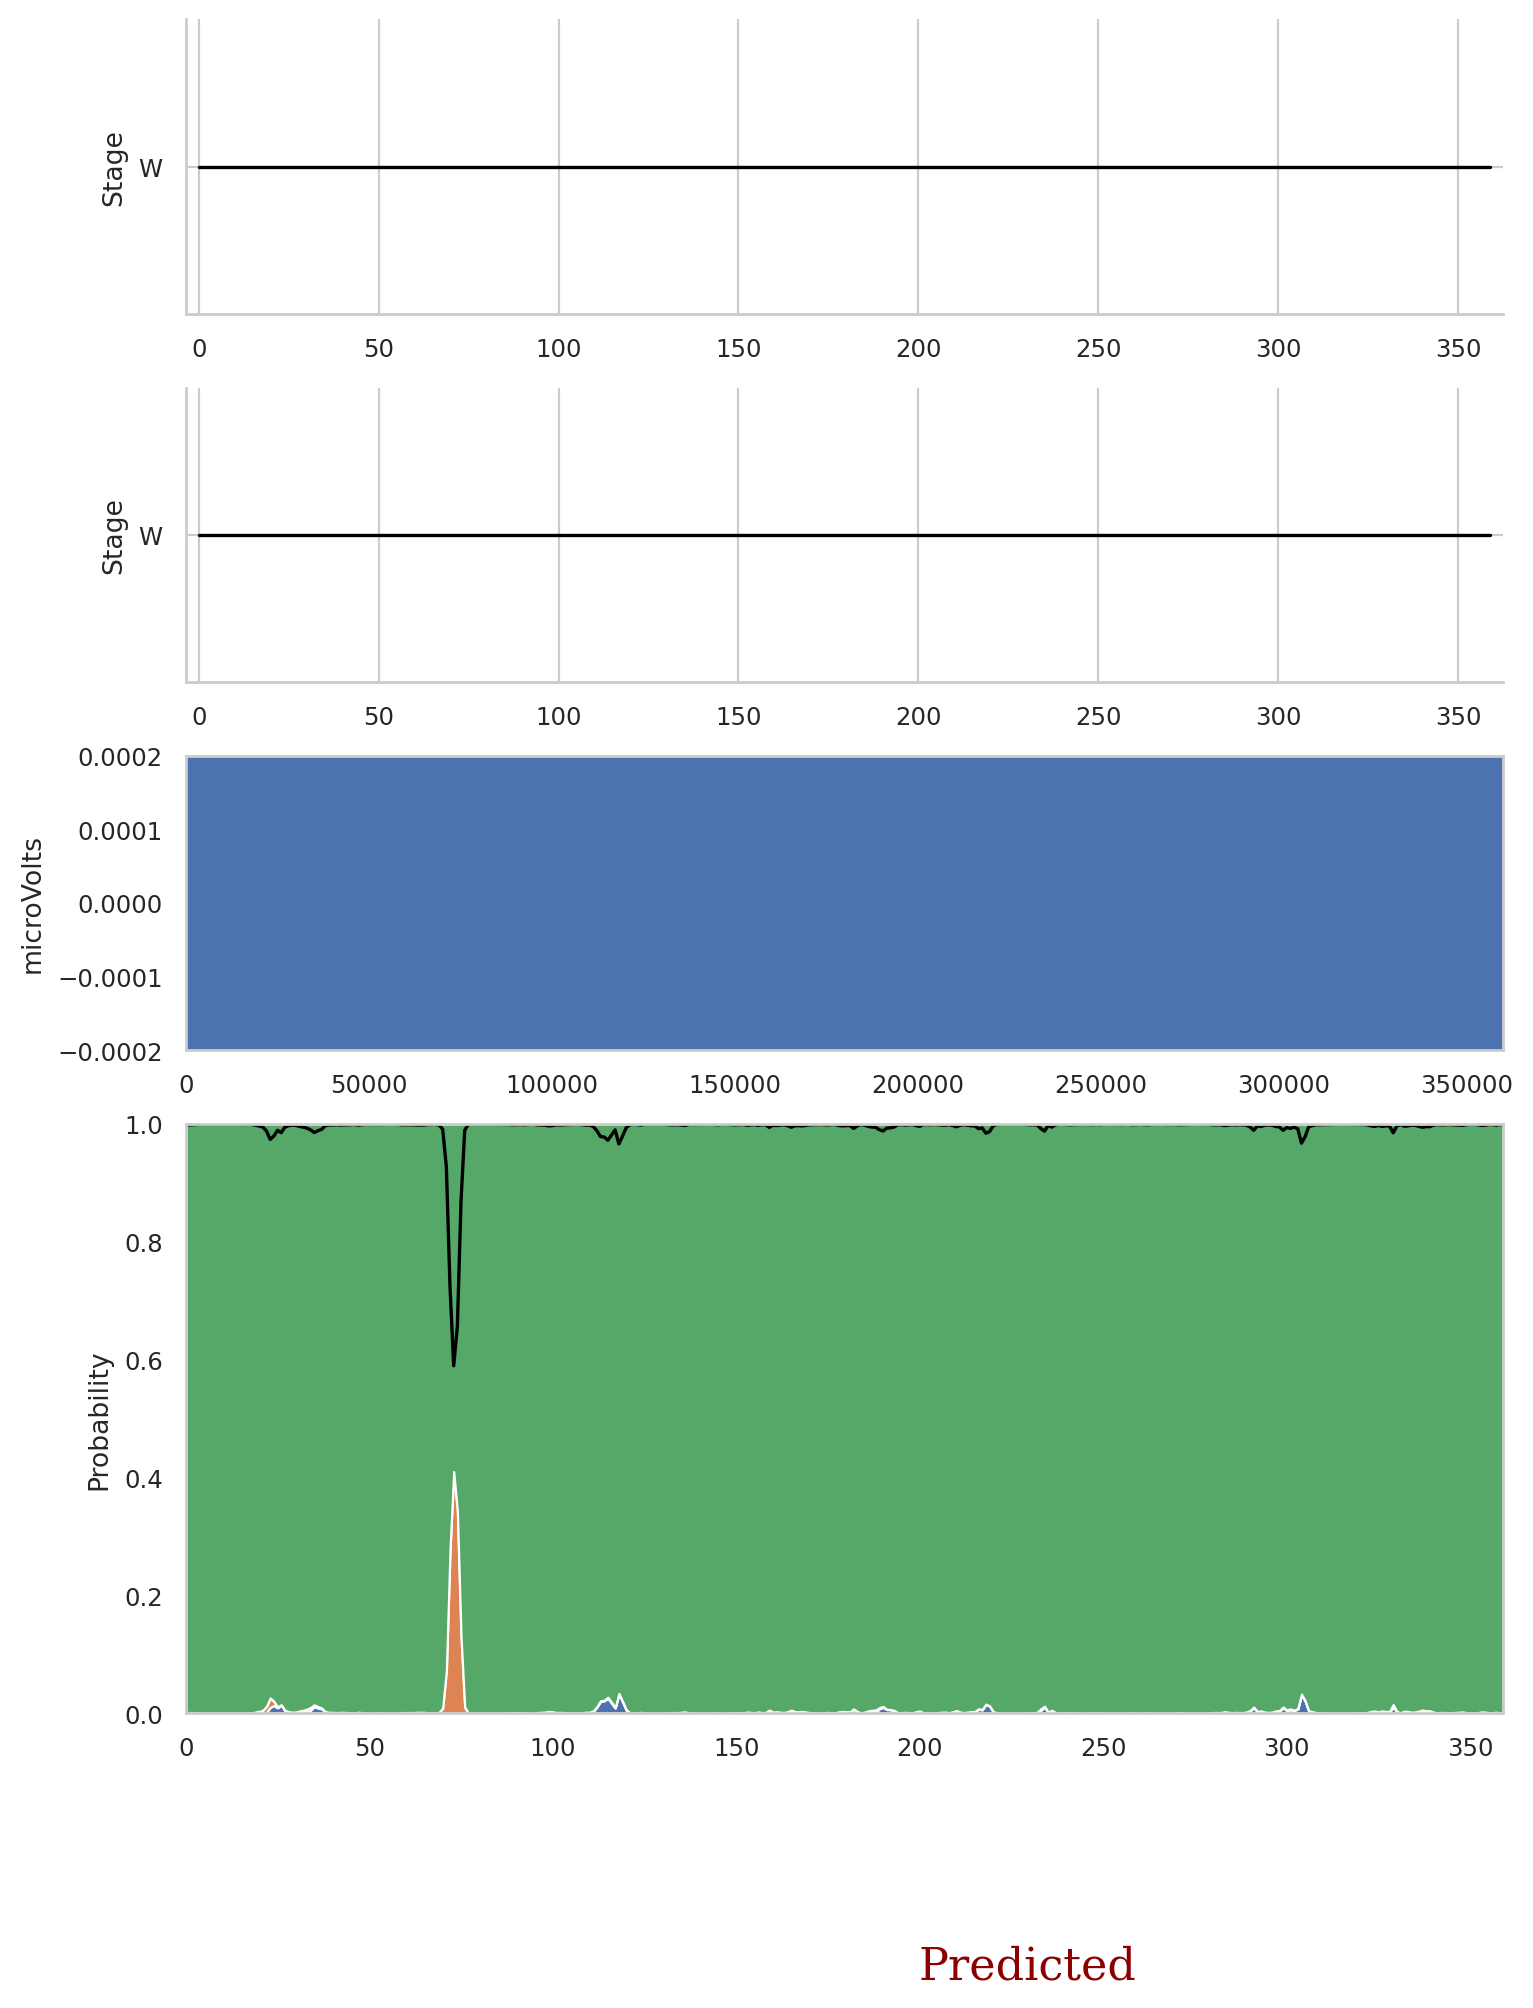

<Figure size 640x480 with 0 Axes>

In [131]:
confidences = []
idx = y_logits.argmax(axis=1)
for logit,idx in zip(y_logits,idx):
    confidences.append(logit[idx].item())
fig,axes = plt.subplots(ncols=1,nrows=4,figsize=(8.5,11),dpi=200,gridspec_kw={'height_ratios': [1,1,1,2]})
lower = 1000
upper = 1360

# true label signal
axes[0].plot(y_true[lower:upper],'black')
axes[0].set_yticks(np.arange(3),labels=['P','S','W'])
axes[0].set_ylabel('Stage')
axes[0].text(200,1,'Reference',fontdict={'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        })
axes[0].spines[['right', 'top']].set_visible(False)
axes[0].margins(.01,.01)

# predicted label signal
axes[1].plot(y_pred[lower:upper],'black')
axes[1].set_yticks(np.arange(3),labels=['P','S','W'])
axes[1].set_ylabel('Stage')
axes[1].text(200,1,'Predicted',fontdict={'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        })
axes[1].spines[['right', 'top']].set_visible(False)
axes[1].margins(.01,.01)

# eeg signal
axes[2].plot(Xs[0][lower+8:upper+8:5].flatten())
axes[2].set_ylim([-.0002,.0002])
axes[2].margins(0,0)
axes[2].set_ylabel('microVolts')

# predicted probability distribution
axes[3].stackplot(torch.arange(len(y_logits[lower:upper])),y_logits[lower:upper].T)
axes[3].plot(confidences[lower:upper],'black')
axes[3].set_ylabel('Probability')
axes[3].margins(0,0)

plt.show()
plt.savefig('out.svg',bbox_inches='tight')

In [125]:
ids = ['A1','A2','A3','A4','B1','B2','B3','B4','C1','C2','C3','C4','C5','C6','C7','C8','D1','D2','D3','D4','D5','D6']
FOLDS = [0,1,2,3,4,5,6,7,8,10,11,12,13,14,18,19,20,21]
criterion = torch.nn.CrossEntropyLoss()
all_metrics = pd.DataFrame()
all_stats = pd.DataFrame()
all_confidences = []
stage_propotions = pd.DataFrame()
recall_cm = torch.zeros((3,3))
precision_cm = torch.zeros((3,3))
for FOLD in FOLDS:
    test_id = ids[FOLD]
    print(test_id)
    subjects = [load_spindle_eeg_label_pair(cohort=id[0],subject=id[1]) for id in [test_id]]
    Xs = [subject[0] for subject in subjects]
    ys = [subject[1] for subject in subjects]
    testloader = DataLoader(dataset=SSDataset(Xs,ys,range(8640)),batch_size=32,shuffle=False)
    model = Gandalf()
    model.load_state_dict(torch.load(f'../spindle_gandalfs/gandalf_spindle_fold_{FOLD}/best_model.pt',map_location='cpu'))
    model.to(DEVICE)
    loss,metrics,y_true,y_pred,y_logits = evaluate(testloader,model,criterion,DEVICE)
    confidences = []
    idx = y_logits.argmax(axis=1)
    for logit,idx in zip(y_logits,idx):
        confidences.append(logit[idx].item())
    all_confidences.append(torch.tensor(confidences).mean())
    recall_cm += confusion_matrix(y_true=y_true,y_pred=y_pred,normalize='true')
    precision_cm += confusion_matrix(y_true=y_true,y_pred=y_pred,normalize='pred')
    all_metrics = pd.concat([all_metrics,pd.Series(metrics,name=f'{FOLD}')],axis=1)
    stage_propotions = pd.concat([stage_propotions,pd.Series((torch.bincount(y_pred.long())/8640).tolist()+['Predicted'],name=f'{FOLD}')],axis=1)
    stage_propotions = pd.concat([stage_propotions,pd.Series((torch.bincount(y_true.long())/8640).tolist()+['Reference'],name=f'{FOLD}')],axis=1)
    df = pd.DataFrame(y_true)
    df.loc[df[0] == 2,0] = 'W'
    df.loc[df[0] == 1,0] = 'S'
    df.loc[df[0] == 0,0] = 'P'
    stats = get_bout_statistics_for_predictions(df[0]).reset_index().melt(id_vars='index')
    stats['type'] = 'Reference'
    all_stats = pd.concat([all_stats,stats],axis=1)
    df = pd.DataFrame(y_pred)
    df.loc[df[0] == 2,0] = 'W'
    df.loc[df[0] == 1,0] = 'S'
    df.loc[df[0] == 0,0] = 'P'
    stats = get_bout_statistics_for_predictions(df[0]).reset_index().melt(id_vars='index')
    stats['type'] = 'Predicted'
    all_stats = pd.concat([all_stats,stats],axis=1)

A1
Extracting EDF parameters from /home/andrew/sleep/data/spindle/CohortA/recordings/A1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|██████████| 270/270 [00:22<00:00, 11.98it/s]


A2
Extracting EDF parameters from /home/andrew/sleep/data/spindle/CohortA/recordings/A2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|██████████| 270/270 [00:23<00:00, 11.67it/s]


A3
Extracting EDF parameters from /home/andrew/sleep/data/spindle/CohortA/recordings/A3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|██████████| 270/270 [00:22<00:00, 11.88it/s]


A4
Extracting EDF parameters from /home/andrew/sleep/data/spindle/CohortA/recordings/A4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|██████████| 270/270 [00:22<00:00, 11.93it/s]


B1
Extracting EDF parameters from /home/andrew/sleep/data/spindle/CohortB/recordings/B1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|██████████| 270/270 [00:22<00:00, 12.01it/s]


B2
Extracting EDF parameters from /home/andrew/sleep/data/spindle/CohortB/recordings/B2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|██████████| 270/270 [00:22<00:00, 12.07it/s]


B3
Extracting EDF parameters from /home/andrew/sleep/data/spindle/CohortB/recordings/B3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|██████████| 270/270 [00:22<00:00, 11.96it/s]


B4
Extracting EDF parameters from /home/andrew/sleep/data/spindle/CohortB/recordings/B4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|██████████| 270/270 [00:22<00:00, 11.96it/s]


C1
Extracting EDF parameters from /home/andrew/sleep/data/spindle/CohortC/recordings/C1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|██████████| 270/270 [00:22<00:00, 11.88it/s]


C3
Extracting EDF parameters from /home/andrew/sleep/data/spindle/CohortC/recordings/C3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|██████████| 270/270 [00:22<00:00, 11.81it/s]


C4
Extracting EDF parameters from /home/andrew/sleep/data/spindle/CohortC/recordings/C4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|██████████| 270/270 [00:22<00:00, 11.83it/s]


C5
Extracting EDF parameters from /home/andrew/sleep/data/spindle/CohortC/recordings/C5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|██████████| 270/270 [00:22<00:00, 11.76it/s]


C6
Extracting EDF parameters from /home/andrew/sleep/data/spindle/CohortC/recordings/C6.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|██████████| 270/270 [00:22<00:00, 11.84it/s]


C7
Extracting EDF parameters from /home/andrew/sleep/data/spindle/CohortC/recordings/C7.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|██████████| 270/270 [00:22<00:00, 11.99it/s]


D3
Extracting EDF parameters from /home/andrew/sleep/data/spindle/CohortD/recordings/D3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|██████████| 270/270 [00:22<00:00, 12.06it/s]


D4
Extracting EDF parameters from /home/andrew/sleep/data/spindle/CohortD/recordings/D4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|██████████| 270/270 [00:22<00:00, 11.88it/s]


D5
Extracting EDF parameters from /home/andrew/sleep/data/spindle/CohortD/recordings/D5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|██████████| 270/270 [00:22<00:00, 11.88it/s]


D6
Extracting EDF parameters from /home/andrew/sleep/data/spindle/CohortD/recordings/D6.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|██████████| 270/270 [00:22<00:00, 11.97it/s]


In [126]:
c = pd.DataFrame([c.item() for c in all_confidences],columns=['c'])
c['f1'] = all_metrics.T['f1'].to_list()

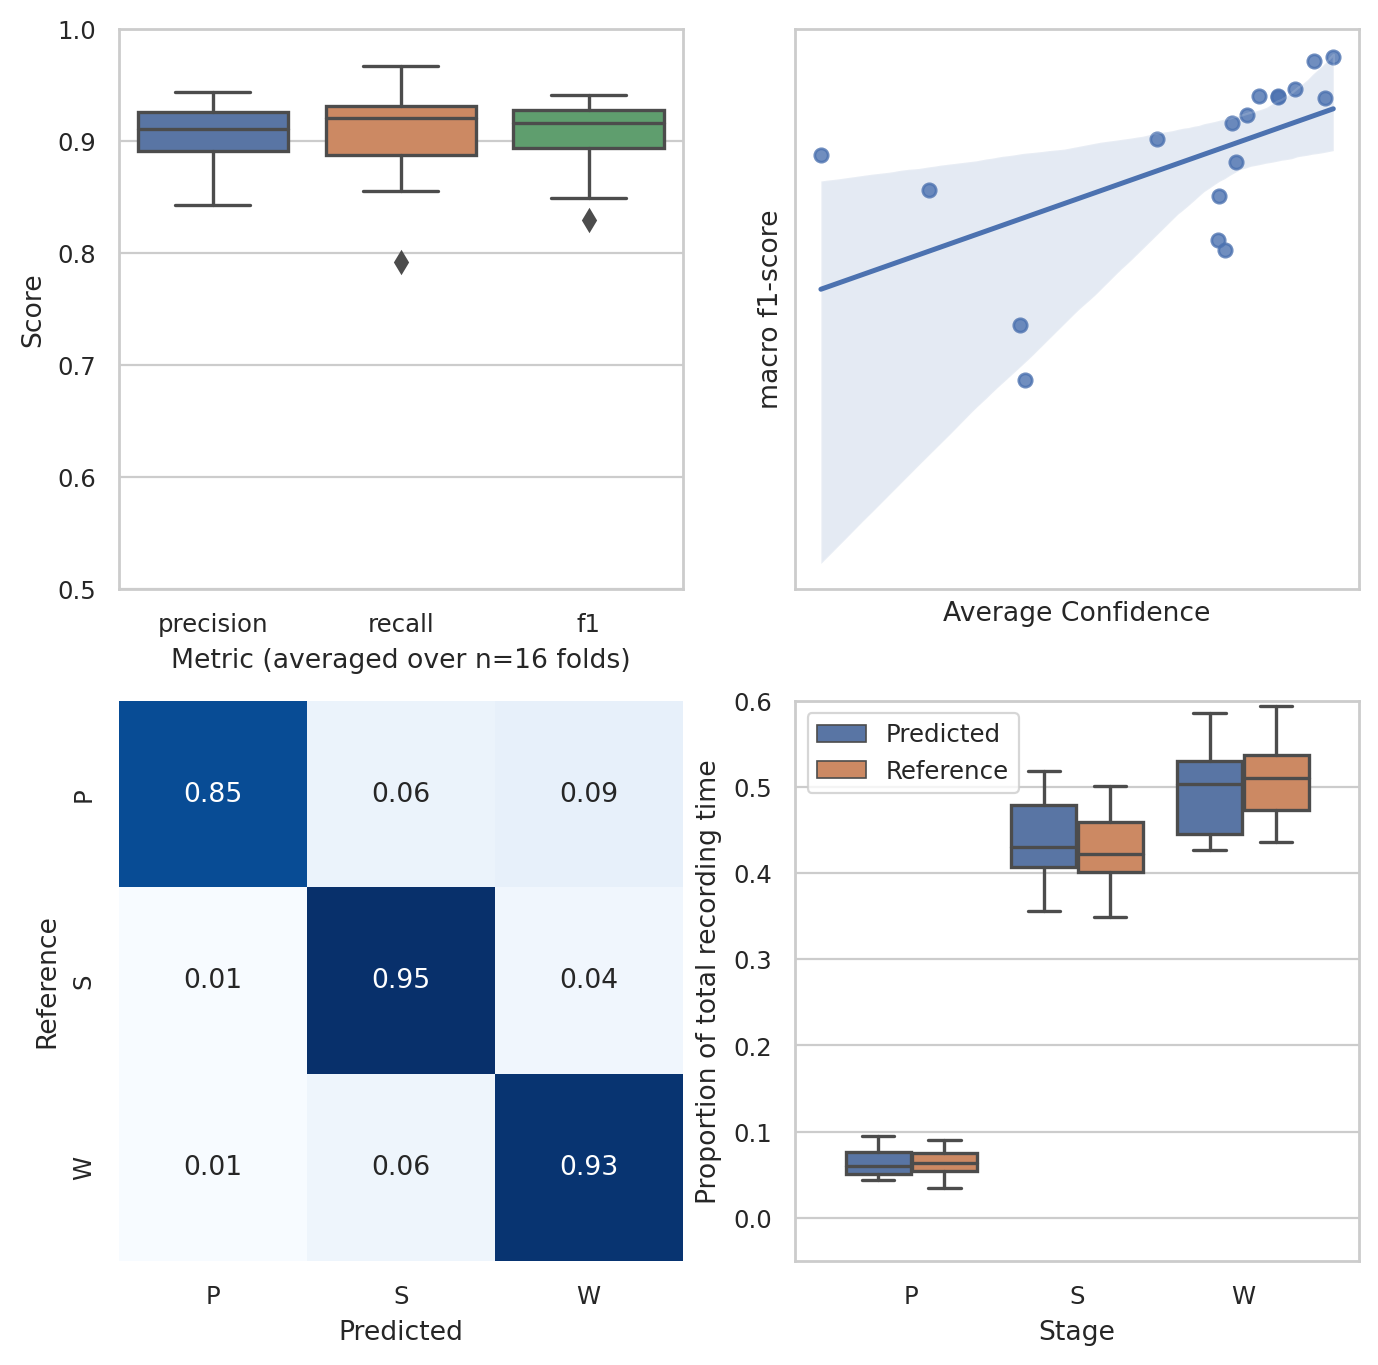

In [132]:
import seaborn as sns
sns.set_theme('paper')
sns.set_style('whitegrid')
fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(8,8),dpi=200)
sns.boxplot(data=stage_propotions.T.melt(id_vars=3),x='variable',y='value',hue=3,ax=axes[1,1])
sns.boxplot(data=all_metrics.T.melt(),y='value',x='variable',ax=axes[0,0])
sns.heatmap(recall_cm/len(FOLDS),annot=True,fmt='.2f',cbar=False,cmap='Blues',ax=axes[1,0])
sns.regplot(data=c,x='c',y='f1',ax=axes[0,1])

axes[0,0].set_ylim(.5,1)
axes[1,1].set_ylim(-.05,.6)
axes[0,0].set_ylabel('Score')
axes[0,0].set_xlabel('Metric (averaged over n=16 folds)')
axes[1,0].set_xticklabels(labels=['P','S','W'])
axes[1,0].set_yticklabels(labels=['P','S','W'])
axes[1,1].set_xticklabels(labels=['P','S','W'])
axes[0,1].set_xlabel('Average Confidence')
axes[0,1].set_ylabel('macro f1-score')
axes[1,0].set_xlabel('Predicted')
axes[1,0].set_ylabel('Reference')
axes[1,1].set_xlabel('Stage')
axes[1,1].set(ylabel='Proportion of total recording time')
axes[1,1].legend()
axes[0,1].set_xticks([])
axes[0,1].set_yticks([])
plt.margins(x=0,y=0)
plt.savefig('spindle_grid.svg',bbox_inches='tight')

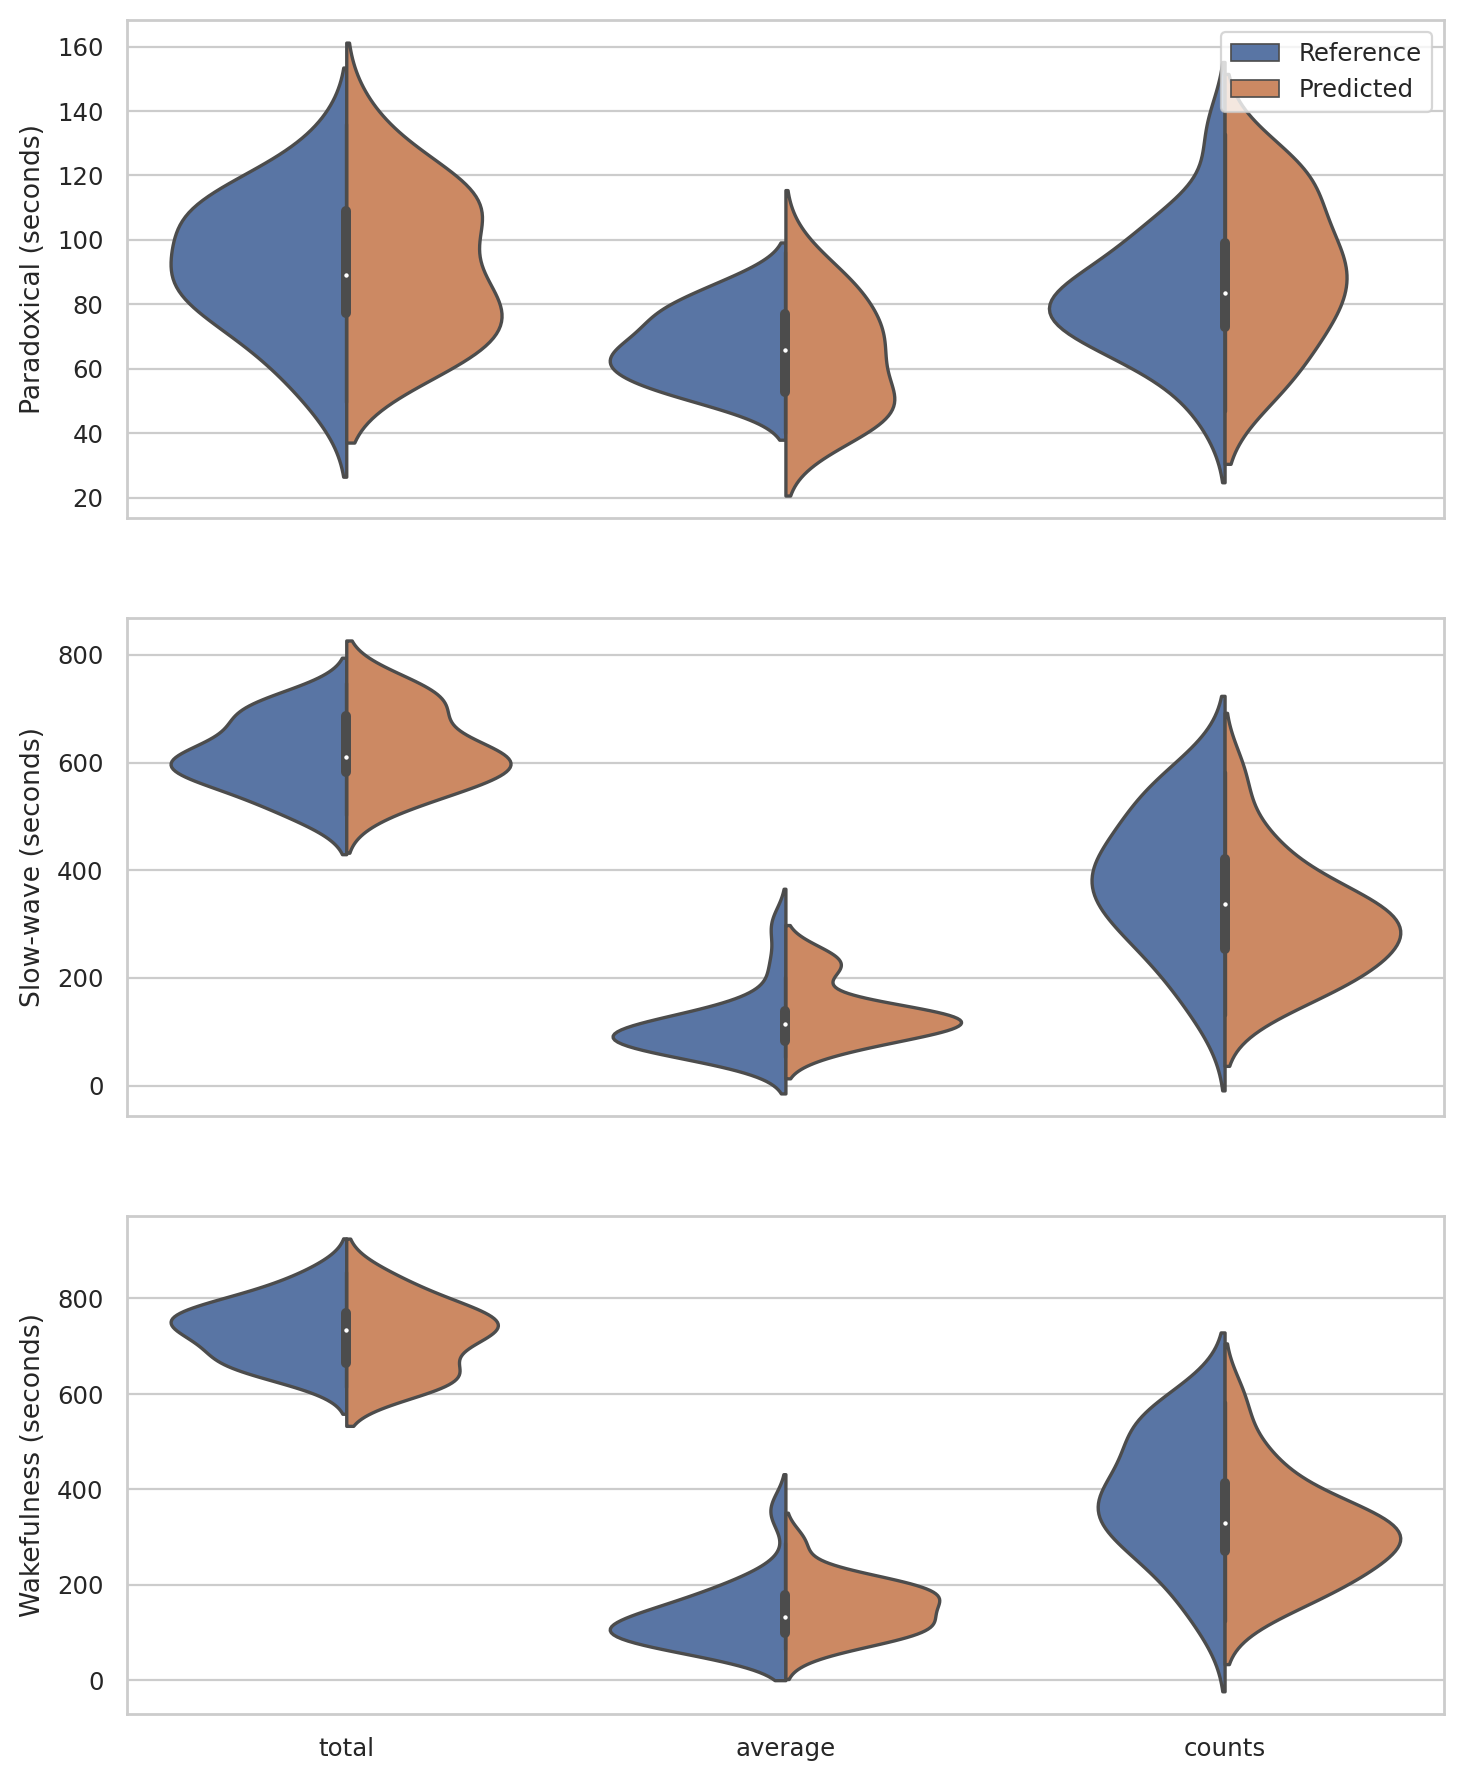

In [196]:
tmp = pd.DataFrame(all_stats.to_numpy().reshape(-1,4))
tmp[2] = tmp[2].astype(float)
fig,axes = plt.subplots(nrows=3,ncols=1,figsize=(8.5,11),dpi=200,gridspec_kw={'height_ratios': [1,1,1]},sharex=True)
sns.violinplot(data=tmp[tmp[1] == 'P'],x=0,y=2,hue=3,split=True,ax=axes[0])
sns.violinplot(data=tmp[tmp[1] == 'S'],x=0,y=2,hue=3,split=True,ax=axes[1])
sns.violinplot(data=tmp[tmp[1] == 'W'],x=0,y=2,hue=3,split=True,ax=axes[2])
axes[0].set_ylabel('Paradoxical (seconds)')
axes[0].set_xlabel('')
axes[0].legend()
axes[1].set_ylabel('Slow-wave (seconds)')
axes[1].set_xlabel('')
axes[1].get_legend().remove()
axes[2].set_ylabel('Wakefulness (seconds)')
axes[2].set_xlabel('')
axes[2].get_legend().remove()

In [231]:
tmp

,0,1,2,3
0,total,P,107.000000,Reference
1,total,P,104.833333,Predicted
2,total,P,93.333333,Reference
3,total,P,80.833333,Predicted
4,total,P,89.333333,Reference
...,...,...,...,...
319,counts,W,187.000000,Predicted
320,counts,W,187.000000,Reference
321,counts,W,190.000000,Predicted
322,counts,W,124.000000,Reference


In [242]:
tmp

,0,1,2,3
0,total,P,107.000000,Reference
1,total,P,104.833333,Predicted
2,total,P,93.333333,Reference
3,total,P,80.833333,Predicted
4,total,P,89.333333,Reference
...,...,...,...,...
319,counts,W,187.000000,Predicted
320,counts,W,187.000000,Reference
321,counts,W,190.000000,Predicted
322,counts,W,124.000000,Reference


,Reference,Predicted
0,107.000000,104.833333
1,93.333333,80.833333
2,89.333333,101.666667
3,105.333333,62.333333
4,84.333333,70.833333
5,89.166667,89.000000
6,81.666667,84.000000
7,77.333333,80.000000
8,109.833333,117.833333
9,94.000000,110.000000


In [230]:
tmp.reset_index().pivot(index='index',columns)

TypeError: pivot() missing 1 required argument: 'columns'

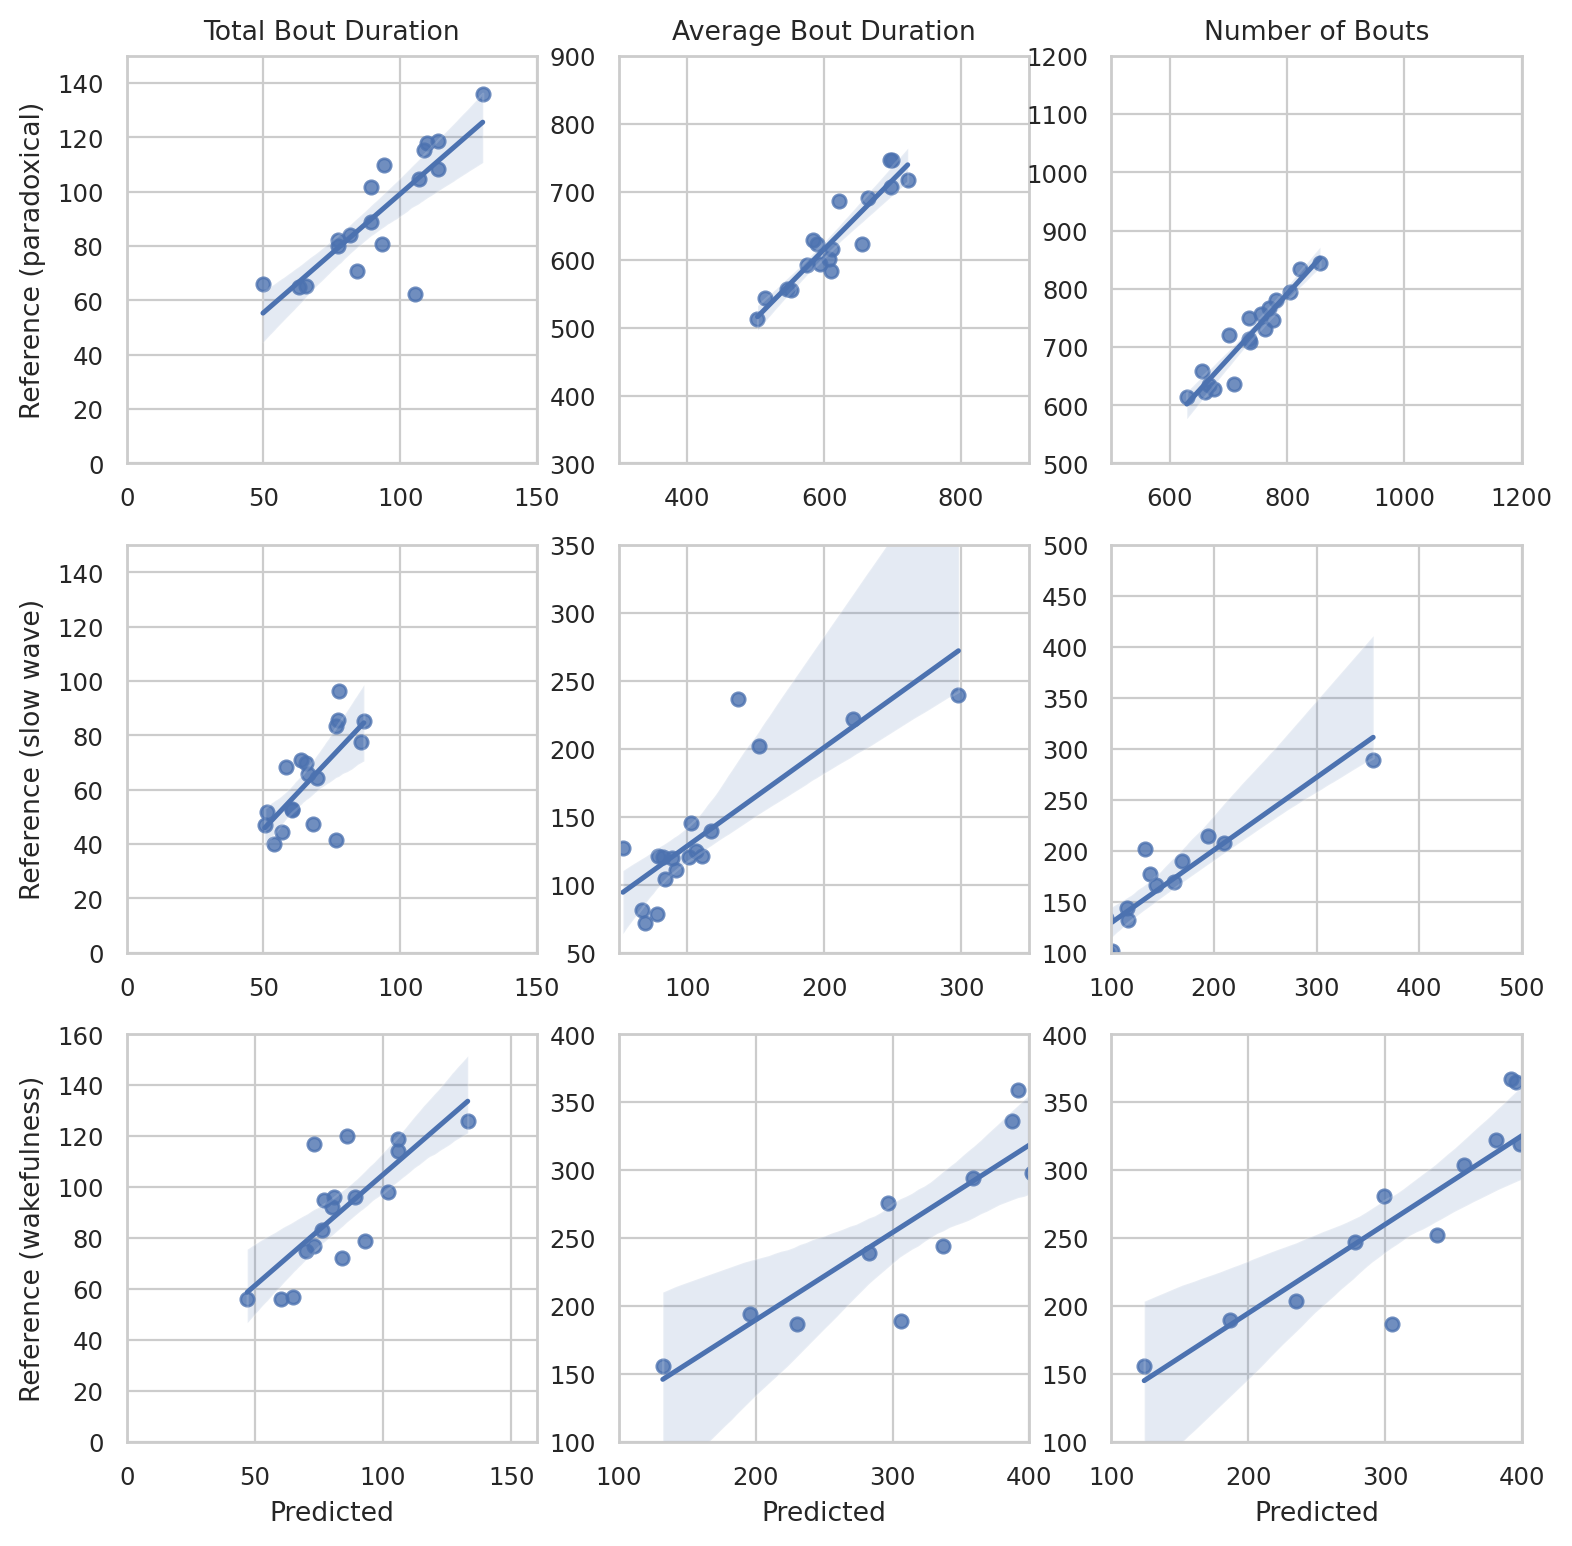

In [245]:
import seaborn as sns
sns.set_theme('paper')
sns.set_style('whitegrid')
fig,axes = plt.subplots(nrows=3,ncols=3,figsize=(9,9),dpi=200)

axes[0,0].set_title('Total Bout Duration')
axes[0,1].set_title('Average Bout Duration')
axes[0,2].set_title('Number of Bouts')
sns.regplot(data=pd.DataFrame(tmp[(tmp[0] == 'total') & (tmp[1] == 'P')][2].to_numpy().reshape(-1,2),columns=['Reference','Predicted']),x='Reference',y='Predicted',ax=axes[0,0])
axes[0,0].set_xlim([0,150])
axes[0,0].set_ylim([0,150])
axes[0,0].set_xlabel('')
axes[0,0].set_ylabel('Reference (paradoxical)')

sns.regplot(data=pd.DataFrame(tmp[(tmp[0] == 'total') & (tmp[1] == 'S')][2].to_numpy().reshape(-1,2),columns=['Reference','Predicted']),x='Reference',y='Predicted',ax=axes[0,1])

axes[0,1].set_xlim([300,900])
axes[0,1].set_ylim([300,900])
axes[0,1].set_xlabel('')
axes[0,1].set_ylabel('')

sns.regplot(data=pd.DataFrame(tmp[(tmp[0] == 'total') & (tmp[1] == 'W')][2].to_numpy().reshape(-1,2),columns=['Reference','Predicted']),x='Reference',y='Predicted',ax=axes[0,2])

axes[0,2].set_xlim([500,1200])
axes[0,2].set_ylim([500,1200])
axes[0,2].set_xlabel('')
axes[0,2].set_ylabel('')

sns.regplot(data=pd.DataFrame(tmp[(tmp[0] == 'average') & (tmp[1] == 'P')][2].to_numpy().reshape(-1,2),columns=['Reference','Predicted']),x='Reference',y='Predicted',ax=axes[1,0])

axes[1,0].set_xlim([0,150])
axes[1,0].set_ylim([0,150])
axes[1,0].set_xlabel('')
axes[1,0].set_ylabel('Reference (slow wave)')

sns.regplot(data=pd.DataFrame(tmp[(tmp[0] == 'average') & (tmp[1] == 'S')][2].to_numpy().reshape(-1,2),columns=['Reference','Predicted']),x='Reference',y='Predicted',ax=axes[1,1])

axes[1,1].set_xlim([50,350])
axes[1,1].set_ylim([50,350])
axes[1,1].set_xlabel('')
axes[1,1].set_ylabel('')

sns.regplot(data=pd.DataFrame(tmp[(tmp[0] == 'average') & (tmp[1] == 'W')][2].to_numpy().reshape(-1,2),columns=['Reference','Predicted']),x='Reference',y='Predicted',ax=axes[1,2])

axes[1,2].set_xlim([100,500])
axes[1,2].set_ylim([100,500])
axes[1,2].set_xlabel('')
axes[1,2].set_ylabel('')

sns.regplot(data=pd.DataFrame(tmp[(tmp[0] == 'counts') & (tmp[1] == 'P')][2].to_numpy().reshape(-1,2),columns=['Reference','Predicted']),x='Reference',y='Predicted',ax=axes[2,0])

axes[2,0].set_xlim([0,160])
axes[2,0].set_ylim([0,160])
axes[2,0].set_xlabel('Predicted')
axes[2,0].set_ylabel('Reference (wakefulness)')

sns.regplot(data=pd.DataFrame(tmp[(tmp[0] == 'counts') & (tmp[1] == 'S')][2].to_numpy().reshape(-1,2),columns=['Reference','Predicted']),x='Reference',y='Predicted',ax=axes[2,1])

axes[2,1].set_xlim([100,400])
axes[2,1].set_ylim([100,400])
axes[2,1].set_xlabel('Predicted')
axes[2,1].set_ylabel('')

sns.regplot(data=pd.DataFrame(tmp[(tmp[0] == 'counts') & (tmp[1] == 'W')][2].to_numpy().reshape(-1,2),columns=['Reference','Predicted']),x='Reference',y='Predicted',ax=axes[2,2])

axes[2,2].set_xlim([100,400])
axes[2,2].set_ylim([100,400])
axes[2,2].set_xlabel('Predicted')
axes[2,2].set_ylabel('')

plt.margins(x=0,y=0)
plt.savefig('reg.svg',bbox_inches='tight')

In [ ]:
loss,report,y_true,y_pred,y_logits = evaluate(devloader,model,criterion,DEVICE)

In [ ]:
df = pd.DataFrame(y_true)
df.loc[df[0] == 2,0] = 'W'
df.loc[df[0] == 1,0] = 'S'
df.loc[df[0] == 0,0] = 'P'
stats = get_bout_statistics_for_predictions(df[0]).reset_index().melt(id_vars='index')

In [ ]:
stats